# PPO and A2C

**Note** : this script is inspired from the 1st assignment (without correction) from the RL course of the MVA master by A. Lazaric and M. Pirotta, on finite MDP and function approximation, which required to complete a partial implementation of A2C for discrete action space. It has been extended to include a different critic and actor architecture, continuous action space, and the clipped and adaptative KL losses required for PPO.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

try :
    import Box2D
except :
    !pip install Box2D
import pickle as pkl

# from pyvirtualdisplay import Display
# from IPython import display as ipythondisplay
# from IPython.display import clear_output
# import base64
######################## Import internal modules 
# import utils
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print("using GPU" if device.type=="cuda" else "using CPU" )
#print("Device name: ", torch.cuda.get_device_name())
from config import reset_config#, get_arguments
from plots import plot_sumup
from ppo import PPOAgent

In [3]:
try :
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd /content/drive/My\ Drive/RL-PPO
except :
    print("Script running locally")

Script running locally


## Setup the environment
See https://github.com/openai/gym/wiki/Leaderboard for description of OpenAIGym environments

Discrete control settings : 
* "Taxi-v3" : episodic & discrete setting both for states and actions (S/N/E/W/Pickup/Dropoff)
* __"CartPole-v0" / "CartPole-v1" : discrete action and continuous state space__
* __"MountainCar-v0" : discrete action and continuous state space__

Continous control settings :
* __"MountainCarContinuous-v0" (both state and action continuous spaces)__
* "LunarLanderContinuous-v2" (requires box2D)
* "CarRacing-v0" : "Discrete control is reasonable in this environment as well" (requires box2D)

* "MsPacman-v0 "(requires the Atari dependency)

Settings used by the authors (requires the MuJoCo dependencies, 30 days free trial) : https://github.com/openai/mujoco-py
* "HalfCheetah-v1" (use v2 now?)
* "Hopper-v1"
* etc.

## Configuration 

See https://github.com/llSourcell/Unity_ML_Agents/blob/master/docs/best-practices-ppo.md for tuning best practice

In [4]:
config = reset_config(print_=True)

Training config : 

{'actor_network': {'lr': 0.001},
 'batch_size': 2048,
 'beta_KL': 3,
 'c1': 1,
 'c2': 0.001,
 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118),
           'adaptative_KL_loss': (0.9882352941176471,
                                  0.5529411764705883,
                                  0.3843137254901961),
           'clipped_loss': (0.5529411764705883,
                            0.6274509803921569,
                            0.796078431372549)},
 'd_targ': 0.01,
 'env': 'CartPole-v1',
 'epochs': 4,
 'eps_clipping': 0.2,
 'gamma': 0.99,
 'lambda': 1,
 'loss_name': 'clipped_loss',
 'max_episodes': 1000,
 'max_steps': 300,
 'optimize_every': 2048,
 'randomize_batch': False,
 'reset_val': None,
 'reward_norm': False,
 'seed': 42,
 'solved_reward': {'CartPole-v1': 300,
                   'LunarLander-v2': 230,
                   'MountainCar-v0': 300,
                   'MountainCarContinuous-v0': 300},
 'std': 0.001,
 'value_network': {'lr': 0.001}}

# Lunar 

In [57]:
#config["reward_norm"]=True
print(config["lambda"]!=1)
config['env'] = 'LunarLander-v2'
config['batch_size'] = 2048
rewards_list = []
loss_list = []
for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

False
-----------------clipped_loss-----------------
{'env': 'LunarLander-v2', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'reward_norm': False, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2048, 'batch_size': 2048, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 42, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Loss :  clipped_loss
Episode 1/1000: Mean rewards: -214.28, Std: 123.44
Episode 25/1000: Mean rewards: -184.03, Std: 103.64
Episode 50/1000: Mean rewards: -174.02, Std: 100.78
Episode 75/1000: Mean rewards: -185.4,

Episode 650/1000: Mean rewards: -144.29, Std: 57.09
Episode 675/1000: Mean rewards: -137.01, Std: 38.54
Episode 700/1000: Mean rewards: -129.76, Std: 40.48
Episode 725/1000: Mean rewards: -125.95, Std: 40.03
Episode 750/1000: Mean rewards: -121.54, Std: 50.88
Episode 775/1000: Mean rewards: -132.03, Std: 41.31
Episode 800/1000: Mean rewards: -137.04, Std: 48.91
Episode 825/1000: Mean rewards: -126.75, Std: 42.41
Episode 850/1000: Mean rewards: -132.18, Std: 36.03
Episode 875/1000: Mean rewards: -126.27, Std: 42.04
Episode 900/1000: Mean rewards: -124.07, Std: 37.1
Episode 925/1000: Mean rewards: -137.65, Std: 44.35
Episode 950/1000: Mean rewards: -129.0, Std: 55.73
Episode 975/1000: Mean rewards: -131.16, Std: 37.84
Episode 999/1000: Mean rewards: -141.93, Std: 44.28
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:01:30.507160


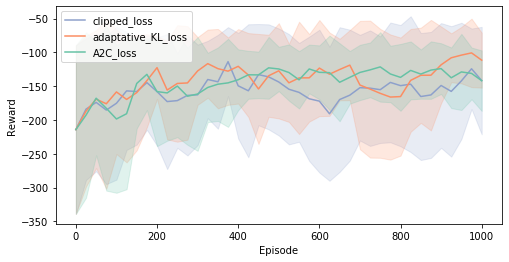

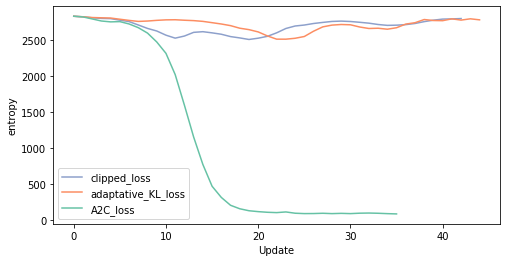

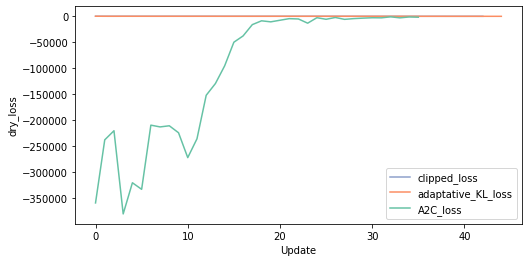

In [58]:
plot_sumup(rewards_list,loss_list,config=config)

# Cartpole

In [11]:
rewards_list = []
loss_list = []
#for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
for loss in ["A2C_loss"]:
    config = reset_config(print_=False)
    config["env"] = 'CartPole-v1'
    if loss=="A2C_loss": 
        config["batch_size"] = 128
        config['epoch']= 1
        config["c2"]=0
    if loss=="clipped_loss": config['epoch']= 8
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    config['d_targ'] = 1
    pprint(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

-----------------A2C_loss-----------------
{'actor_network': {'lr': 0.001},
 'batch_size': 128,
 'beta_KL': 3,
 'c1': 1,
 'c2': 0,
 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118),
           'adaptative_KL_loss': (0.9882352941176471,
                                  0.5529411764705883,
                                  0.3843137254901961),
           'clipped_loss': (0.5529411764705883,
                            0.6274509803921569,
                            0.796078431372549)},
 'd_targ': 1,
 'env': 'CartPole-v1',
 'epoch': 1,
 'epochs': 4,
 'eps_clipping': 0.2,
 'gamma': 0.99,
 'lambda': 1,
 'loss_name': 'A2C_loss',
 'max_episodes': 1000,
 'max_steps': 300,
 'optimize_every': 2048,
 'randomize_batch': False,
 'reset_val': None,
 'reward_norm': False,
 'seed': 42,
 'solved_reward': {'CartPole-v1': 300,
                   'LunarLander-v2': 230,
                   'MountainCar-v0': 300,
                   'MountainCarContinuous-v0': 300},
 'std': 0.001,
 'value_

In [10]:
config["env"] = 'CartPole-v1'
#print(config["lambda"]!=1)
config["batch_size"] = 128
#config['epoch']=8
#config['value_network'] = {'lr': 1e-3}
#config['actor_network'] = {'lr': 1e-3}
rewards_list = []
loss_list = []
#for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
for loss in ["A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

-----------------A2C_loss-----------------
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'reward_norm': False, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2048, 'batch_size': 128, 'randomize_batch': False, 'seed': 42, 'loss_name': 'A2C_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}, 'reset_val': None}
Loss :  A2C_loss
Episode 1/1000: Mean rewards: 19.9, Std: 8.5
Episode 25/1000: Mean rewards: 20.08, Std: 8.08
Episode 50/1000: Mean rewards: 20.7, Std: 10.55
Episode 75/1000: Mean rewards: 21.22, Std: 11.71

In [ ]:
#PPO VERSION 1
plot_sumup(rewards_list,loss_list,config=config)

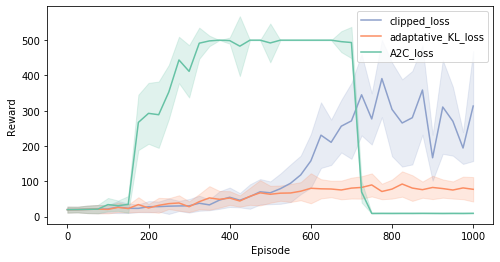

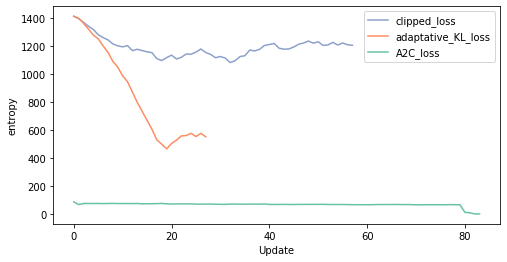

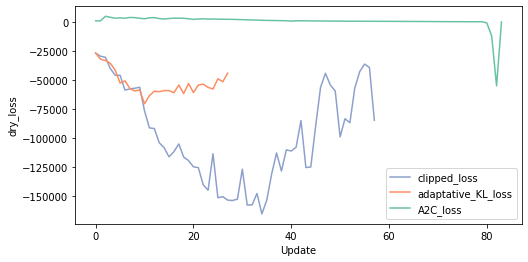

In [56]:
#PPO VERSION 1
plot_sumup(rewards_list,loss_list,config=config)

In [7]:
config["env"] = 'CartPole-v1'
print(config["lambda"]!=1)
config["batch_size"] = 128
rewards_list = []
loss_list = []
for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

False
-----------------clipped_loss-----------------
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'reward_norm': False, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2048, 'batch_size': 128, 'randomize_batch': False, 'seed': 42, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}, 'reset_val': None}
Loss :  clipped_loss
Episode 1/1000: Mean rewards: 19.9, Std: 8.5
Episode 25/1000: Mean rewards: 20.08, Std: 8.08
Episode 50/1000: Mean rewards: 20.7, Std: 10.55
Episode 75/1000: Mean rewards:

KeyboardInterrupt: 